In [1]:
import pandas as pd
import numpy as np
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
import math
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans
import scipy

In [51]:
def plot_clusters(npos, df_in, n_clusters=4, title='', out_name=None):
    
    y_pred = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(npos)
    
    offset = (max(npos[:, 0]) - min(npos[:, 0]))*0.01
    
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    s = 50
    plt.scatter(npos[:, 0], npos[:, 1], c=y_pred, s=s, )
    plt.title("Clusters")

    for i, n in enumerate(npos):
        plt.text(npos[i, 0] + offset, npos[i, 1], df_in.index[i], fontsize='large')

    # plt.legend(scatterpoints=1, loc='best', shadow=False, )
    plt.title(title)
    
    if out_name is not None:
        plt.savefig(out_name)

    plt.show()
    

def plot_mds(df_in, npos, label='NMDS', out_name=None):
    fig = plt.figure()
    fig.set_size_inches(10, 7)
    s = 50
    offset = (max(npos[:, 0]) - min(npos[:, 0]))*0.01
    plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label=label )

    for i, n in enumerate(npos):
        plt.text(npos[i, 0]+offset, npos[i, 1], df_in.index[i], )

    plt.legend(scatterpoints=1, loc='best', shadow=False, )
    if out_name is not None:
        plt.savefig(out_name)

    plt.show()
    
    
def plot_scree(df_in, metric=False, out_name=None, title=''):
    stress = []
    # Max value for n_components
    max_range = len(df_in) - 1
    for dim in range(1, max_range):
        # Set up the MDS object
        mds = manifold.MDS(n_components=dim, dissimilarity='precomputed', metric=metric, eps=1e-14, max_iter=1000) # random_state=42, 
        # Apply MDS
        pts = mds.fit_transform(df_in)
        # Retrieve the stress value
        stress.append(mds.stress_)
    # Plot stress vs. n_components    
    plt.plot(range(1, max_range), stress)
    plt.xticks(range(1, max_range, 2))
    plt.xlabel('n_components')
    plt.ylabel('stress')
    plt.title(title)
    
    if out_name is not None:
        plt.savefig(out_name)
        
    plt.show()
    
    
def sim_to_dis(df_in, sqrt=False):
    if sqrt:
        df_in = np.sqrt(df_in.max().max()+1 - df_in)
    else:
        df_in = df_in.max().max()+1 - df_in
        
    np.fill_diagonal(df_in.values, 0)
        
    return df_in

# First example: Let's look at road distances between SA cities

Input dataset has the distance between cities by road.

In [64]:
df_sa = pd.read_csv('sa_dist.csv')
df_sa.set_index('City', inplace=True)

## Manifold creation

Here, we create a metric manifold with 2 components

In [67]:
mds_sa = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)

# fit the data with MDS
npos_sa = mds_sa.fit_transform(df_sa)

Plotting the coords shows something similar to what we might see on a map, if we rotated the map a bit...

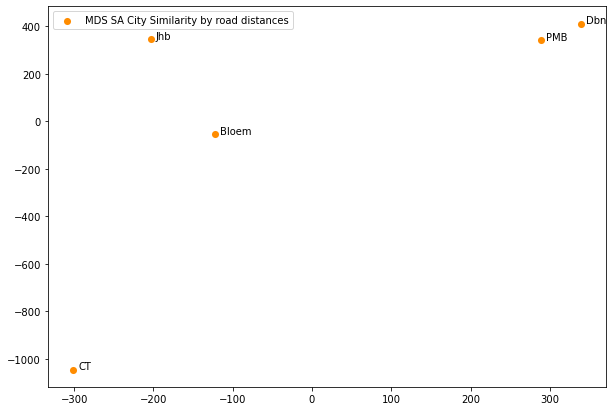

In [68]:
plot_mds(df_sa, npos_sa, label='MDS SA City Similarity by road distances', out_name='sa_city.png')

# Non-metric MDS: country similarities
This is based on the 1968 study where students were asked to rate how similar different countries are.  The similarities provided are the averages.


In [3]:
df = pd.read_csv('country_sim.csv')
df.fillna(0, inplace=True)
df.set_index('Country', inplace=True)

# make it symmetric
df = df + df.T

In [55]:
df

,Brazil,Congo,Cuba,Egypt,France,India,Israel,Japan,China,Russia,USA,Yugoslavia
Country,,,,,,,,,,,,
Brazil,0.00,4.83,5.28,3.44,4.72,4.50,3.83,3.50,2.39,3.06,5.39,3.17
Congo,4.83,0.00,4.56,5.00,4.00,4.83,3.33,3.39,4.00,3.39,2.39,3.50
Cuba,5.28,4.56,0.00,5.17,4.11,4.00,3.61,2.94,5.50,5.44,3.17,5.11
Egypt,3.44,5.00,5.17,0.00,4.78,5.83,4.67,3.83,4.39,4.39,3.33,4.28
France,4.72,4.00,4.11,4.78,0.00,3.44,4.00,4.22,3.67,5.06,5.94,4.72
India,4.50,4.83,4.00,5.83,3.44,0.00,4.11,4.50,4.11,4.50,4.28,4.00
Israel,3.83,3.33,3.61,4.67,4.00,4.11,0.00,4.83,3.00,4.17,5.94,4.44
Japan,3.50,3.39,2.94,3.83,4.22,4.50,4.83,0.00,4.17,4.61,6.06,4.28
China,2.39,4.00,5.50,4.39,3.67,4.11,3.00,4.17,0.00,5.72,2.56,5.06


For this one, if you perform NMDS you'll find it does not converge!  Try it!  Just remove init=pos_cnt from the fit below and view the results...

In [5]:

nmds_cnt = manifold.MDS(n_components=2, metric=False, max_iter=5000, eps=1e-15,
                    dissimilarity="precomputed",  n_jobs=1,
                    verbose=1) #  random_state=100110,

mds_cnt = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)


In [6]:
# If you want to convert the similarities to rank explicitly
cnt_rank = scipy.stats.stats.rankdata(df).reshape(12, 12) # sim_to_dis(df, sqrt=False)).reshape(12, 12)

In [8]:
# perform metric MDS on the dissimilarities (here we  have converted by taking 7-similarity)
pos_cnt = mds_cnt.fit(sim_to_dis(df, sqrt=False)).embedding_
# perform non-metric MDS on the same dataset, but use the output from metric MDS as the starting point
npos_cnt = nmds_cnt.fit_transform(sim_to_dis(df, sqrt=False), init=pos_cnt)
print(nmds_cnt.stress_)

breaking at iteration 2 with stress 0.6504310793202348
0.6504310793202348


/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/sklearn/manifold/_mds.py:259: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


In [1203]:
# you can do PCA on it too if you want
#clf = PCA(n_components=2)
#npos = clf.fit_transform(npos)

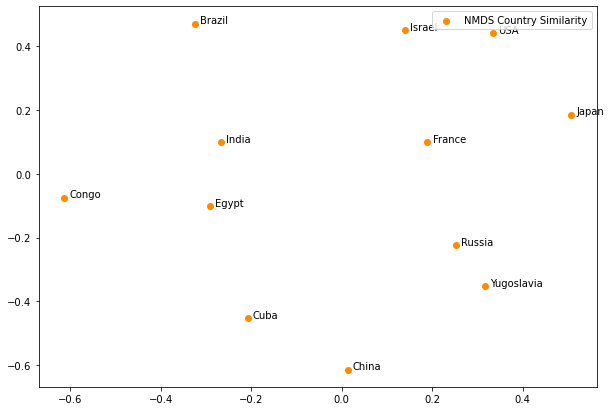

In [9]:
plot_mds(df, npos_cnt, label='NMDS Country Similarity')

Try clustering the datapoints with k-means and see what comes out!

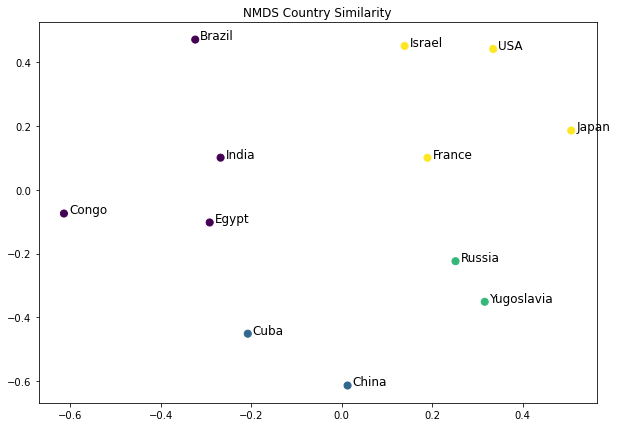

In [10]:
plot_clusters(npos_cnt, df, n_clusters=4, out_name='country_sim_clusters.png', title='NMDS Country Similarity')

We can also have a look at the scree plot. It looks like 3 components isn't really enough, nevermind 2!  We should be careful with our results...

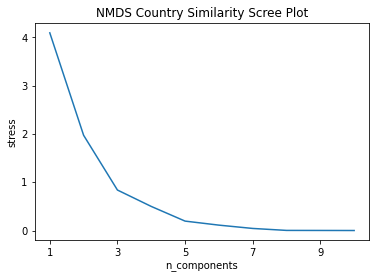

In [13]:
plot_scree(df, metric=False, out_name='scree_country_sim.png', title='NMDS Country Similarity Scree Plot')

# Metric MDS: Economic Indicators

Here we look at the economic and demographic indicators of 25 countries from 1990.

In [14]:
dfc = pd.read_csv('economic_indicators.csv')
dfc.set_index('Country', inplace=True)

In [50]:
dfc

Now create a metric manifold.  Try it with different values and see what happens :) 


Note that the features are on different scales - scale to variance of 1 and mean of 0 first.

In [16]:
mds_eco = manifold.MDS(n_components=2, metric=True, max_iter=50, eps=1e-12,
                    dissimilarity="precomputed", n_jobs=1,
                    n_init=4) # random_state=42

# Note that 
dfcm = StandardScaler().fit_transform(dfc)

# now get the Euclidean pairwise distances on the scaled data
D = pairwise_distances(dfcm)


In [69]:
D

array([[0.        , 0.50038391, 2.36999668, 2.73574972, 4.18954168,
        2.3171587 , 1.05596321, 3.73039586, 0.68899596, 0.58363725,
        2.55624484, 1.2849406 , 2.84681578, 1.4849127 , 2.19082374,
        1.84594462, 2.88924327, 5.0918539 , 2.59872005, 3.09965218,
        2.3289297 , 1.21863321, 1.68526509, 2.80776403, 2.45713358],
       [0.50038391, 0.        , 1.92663024, 2.27472341, 4.26843342,
        2.4370932 , 1.11247517, 3.85366141, 0.89296007, 0.72804535,
        2.43654358, 1.41024309, 2.39703604, 1.26251387, 2.28735795,
        1.67587552, 2.49255884, 5.20783752, 2.15835793, 3.24044987,
        2.43020726, 1.36877247, 1.67003811, 2.33549618, 2.54529438],
       [2.36999668, 1.92663024, 0.        , 0.48776221, 5.59882107,
        3.92479652, 2.66882601, 5.21532452, 2.56279097, 2.49903026,
        2.84339818, 3.03277049, 0.78111146, 1.48263628, 3.69258135,
        2.52859917, 1.18228769, 6.48012172, 0.42167332, 4.57512845,
        3.95756952, 2.9725537 , 2.64409716, 0.

7.905115889912319


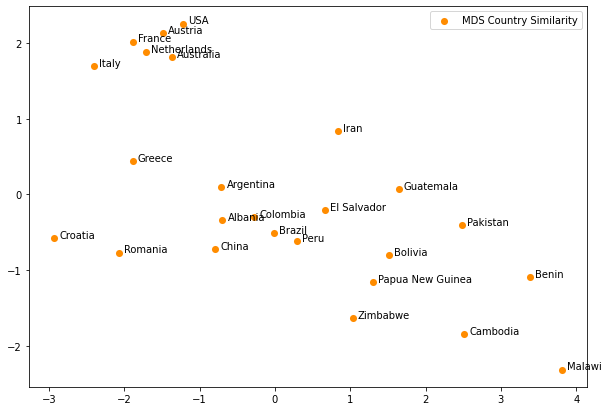

In [17]:
# now fit MDS on this dataset
npos_eco = mds_eco.fit_transform(D)
print(mds_eco.stress_)

plot_mds(dfc, npos_eco, out_name='city_eco.png', label='MDS Country Similarity')

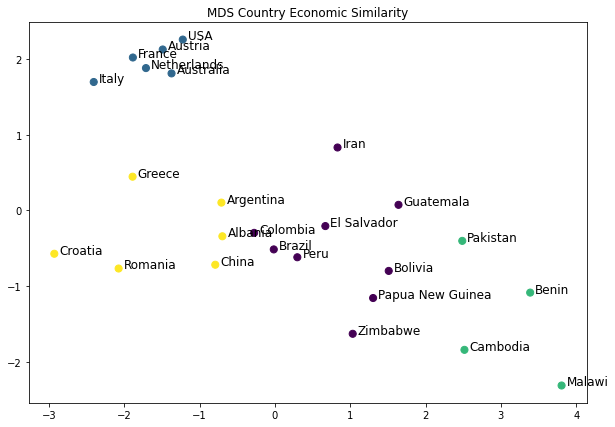

In [18]:
plot_clusters(npos_eco, dfc, n_clusters=4, out_name='country_eco_clusters.png', title='MDS Country Economic Similarity')

Looks like 2 components is decent... maybe 3 would be better though

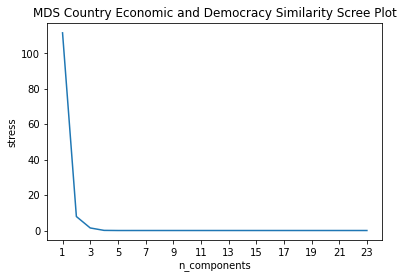

In [57]:
plot_scree(D, metric=True, out_name='scree_country_eco.png', title='MDS Country Economic and Democracy Similarity Scree Plot')

# Non-metric MDS: Letter recognition

Here we look at the similarity between different letters.  This is based on two studies (see lecture notes) where the number of times people misheard letters for other letters was used as the similarity.  Note that below, letters.csv is the original data, and plaindist.csv is some other dataset that shows similar stuff.

In [52]:

dfl = pd.read_csv('letters.csv')
dfl.set_index('letter', inplace=True)

In [53]:
# convert the similarity to distances
dfl1k = sim_to_dis(dfl)

In [54]:
dfl1k

,w,g,c,q,p,t,b,d,e,u,...,j,k,m,n,a,o,i,r,y,z
letter,,,,,,,,,,,,,,,,,,,,,
w,0,841,841,839,839,837,812,820,829,817,...,834,826,822,808,764,770,825,838,831,750
g,841,0,806,705,662,719,665,696,605,625,...,827,842,822,813,808,820,834,837,835,842
c,841,806,0,774,462,573,644,757,718,769,...,831,836,829,821,836,842,839,844,835,839
q,839,705,774,0,401,582,710,741,729,694,...,828,827,837,835,836,838,834,837,842,833
p,839,662,462,401,0,61,610,612,564,752,...,821,802,814,818,831,834,834,846,843,813
t,837,719,573,582,61,0,620,646,560,807,...,833,828,832,827,827,807,832,837,838,837
b,812,665,644,710,610,620,0,525,468,708,...,812,834,826,824,820,833,832,844,839,821
d,820,696,757,741,612,646,525,0,429,746,...,823,835,831,820,819,837,833,842,840,833
e,829,605,718,729,564,560,468,429,0,657,...,837,831,775,735,821,820,733,828,835,837


Try different iterations and stuff here, see how quickly it changes!

3.755207744859613


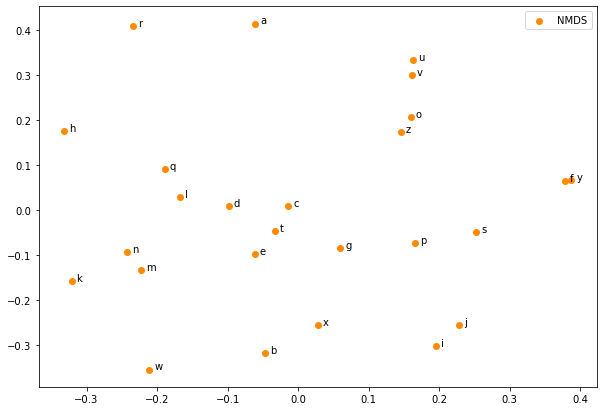

In [22]:
nmds_let = manifold.MDS(n_components=5, metric=False, max_iter=50, eps=1e-15,
                    dissimilarity="precomputed",  n_jobs=1,
                    n_init=1) # random_state=42,

npos_let = nmds_let.fit_transform(dfl1k)

print(nmds_let.stress_)

plot_mds(dfl1k, npos_let)

In [23]:
dfll = pd.read_csv('plaindist.csv')
letters = [chr(97+i) for i in range(26)]
dfll.columns = ['letter'] + letters
def to_letter(i):
    return chr(96+i)

dfll['letter'] = dfll.letter.apply(to_letter)
dfll.set_index('letter', inplace=True)
idx = np.triu(dfll.values>0)
# pd.np.tril(x.corr().values)

dflm = dfll.mask(idx).fillna(0)
dflm = dflm + dflm.T
dflm = sim_to_dis(dflm, sqrt=True)

In [24]:
dfll

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
letter,,,,,,,,,,,,,,,,,,,,,
a,0.000000,61.109804,76.513725,61.250980,60.345098,73.243137,73.498039,65.388235,60.835294,65.376471,...,92.937255,54.133333,64.737255,70.823529,73.454902,78.443137,69.823529,57.952941,72.043137,62.050980
b,61.109804,0.000000,50.776471,28.705882,23.729412,38.196078,44.309804,26.898039,57.223529,49.874510,...,77.309804,25.776471,33.250980,59.015686,37.992157,66.603922,58.752941,58.215686,63.560784,40.188235
c,76.513725,50.776471,0.000000,46.556863,44.639216,49.200000,18.050980,61.007843,53.725490,42.886275,...,59.301961,62.396078,42.592157,49.525490,41.490196,65.364706,70.588235,62.270588,61.647059,44.815686
d,61.250980,28.705882,46.556863,0.000000,34.513725,44.556863,51.094118,40.207843,37.607843,35.333333,...,63.035294,37.792157,39.596078,53.023529,21.231373,58.109804,72.996078,57.760784,60.313725,42.000000
e,60.345098,23.729412,44.639216,34.513725,0.000000,19.596078,50.776471,31.262745,44.717647,49.870588,...,75.337255,27.231373,31.066667,44.752941,38.011765,62.317647,62.349020,41.639216,49.941176,28.623529
f,73.243137,38.196078,49.200000,44.556863,19.596078,0.000000,56.647059,40.960784,42.839216,53.356863,...,81.200000,34.662745,44.537255,39.478431,44.823529,53.019608,63.435294,48.254902,47.615686,46.031373
g,73.498039,44.309804,18.050980,51.094118,50.776471,56.647059,0.000000,58.549020,57.470588,46.992157,...,60.309804,63.192157,42.470588,57.231373,45.274510,67.792157,63.956863,62.439216,68.098039,47.580392
h,65.388235,26.898039,61.007843,40.207843,31.262745,40.960784,58.549020,0.000000,69.329412,51.000000,...,75.894118,30.972549,42.549020,68.705882,35.282353,62.027451,43.219608,56.196078,64.913725,50.623529
i,60.835294,53.592157,53.725490,37.607843,44.717647,35.341176,57.470588,58.223529,0.000000,37.278431,...,84.549020,53.007843,52.396078,21.815686,50.321569,60.635294,85.984314,45.650980,37.286275,41.003922


13.174097849735988


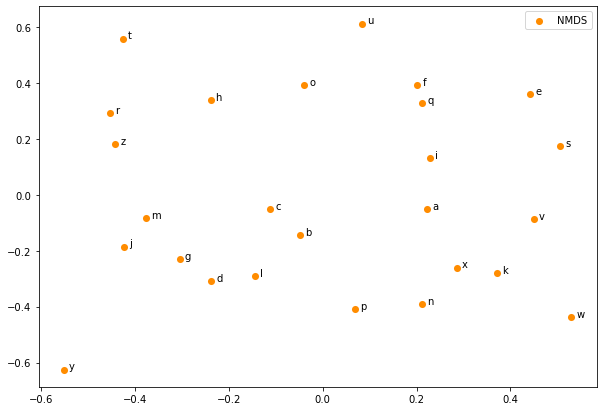

In [26]:
nmds_let = manifold.MDS(n_components=2, metric=False, max_iter=1000, eps=1e-15,
                    dissimilarity="precomputed",  n_jobs=1,
                    n_init=4) # random_state=42,

npos_let = nmds_let.fit_transform(dflm)

print(nmds_let.stress_)

plot_mds(dflm, npos_let)

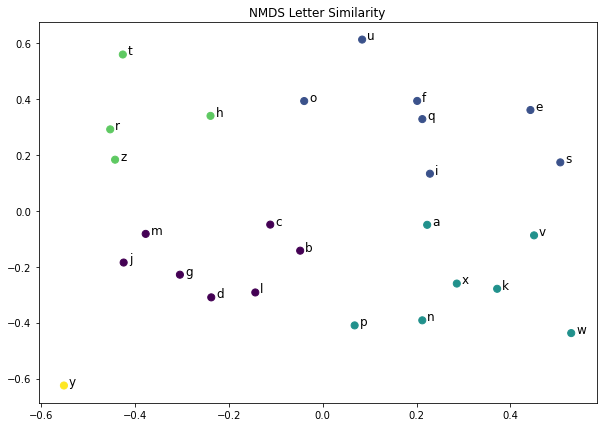

In [27]:

plot_clusters(npos_let, dfll, 5, title='NMDS Letter Similarity', out_name='letter_clusters.png')

# Classical MDS

In [70]:
# Travel times in minutes
dftr = pd.read_csv('uk_train_times.csv')
dftr.fillna(0, inplace=True)
dftr.set_index('City', inplace=True)
dftr = dftr + dftr.T

In [29]:
dftr

,London,Edinburgh,Glasgow,Sheffield,Manchester,Leeds,Cambridge,Oxford,Bristol
City,,,,,,,,,
London,0.0,250.0,280.0,138.0,142.0,138.0,49.0,52.0,100.0
Edinburgh,250.0,0.0,75.0,223.0,192.0,182.0,329.0,322.0,345.0
Glasgow,280.0,75.0,0.0,271.0,196.0,242.0,366.0,338.0,359.0
Sheffield,138.0,223.0,271.0,0.0,50.0,54.0,200.0,159.0,167.0
Manchester,142.0,192.0,196.0,50.0,0.0,54.0,212.0,166.0,187.0
Leeds,138.0,182.0,242.0,54.0,54.0,0.0,194.0,252.0,205.0
Cambridge,49.0,329.0,366.0,200.0,212.0,194.0,0.0,144.0,179.0
Oxford,52.0,322.0,338.0,159.0,166.0,252.0,144.0,0.0,98.0
Bristol,100.0,345.0,359.0,167.0,187.0,205.0,179.0,98.0,0.0


In [30]:
# distances in KM
dfdis = pd.read_csv('uk_city_dist.csv')
dfdis.fillna(0, inplace=True)
dfdis.set_index('City', inplace=True)
dfdis = dfdis + dfdis.T

In [31]:
dfdis

,London,Edinburgh,Glasgow,Sheffield,Manchester,Leeds,Cambridge,Oxford,Bristol
City,,,,,,,,,
London,0.0,534.0,556.0,228.0,262.0,272.0,79.0,83.0,172.0
Edinburgh,534.0,0.0,67.0,307.0,282.0,262.0,470.0,485.0,502.0
Glasgow,556.0,67.0,0.0,330.0,296.0,289.0,498.0,499.0,503.0
Sheffield,228.0,307.0,330.0,0.0,52.0,46.0,169.0,182.0,228.0
Manchester,262.0,282.0,296.0,52.0,0.0,58.0,213.0,204.0,227.0
Leeds,272.0,262.0,289.0,46.0,58.0,0.0,210.0,228.0,270.0
Cambridge,79.0,470.0,498.0,169.0,213.0,210.0,0.0,107.0,205.0
Oxford,83.0,485.0,499.0,182.0,204.0,228.0,107.0,0.0,99.0
Bristol,172.0,502.0,503.0,228.0,227.0,270.0,205.0,99.0,0.0


## Using iterative methods

In [32]:
mds_uk = manifold.MDS(n_components=2, metric=True, max_iter=1000, eps=1e-12,
                    dissimilarity="precomputed", n_jobs=1,
                    n_init=4, random_state=42)



In [33]:
npos_uk_dist = mds_uk.fit_transform(dfdis)

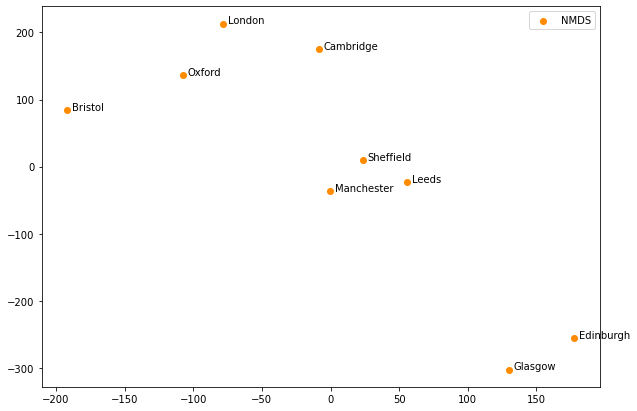

In [34]:
plot_mds(dfdis, npos_uk_dist, out_name='city_dist.png')

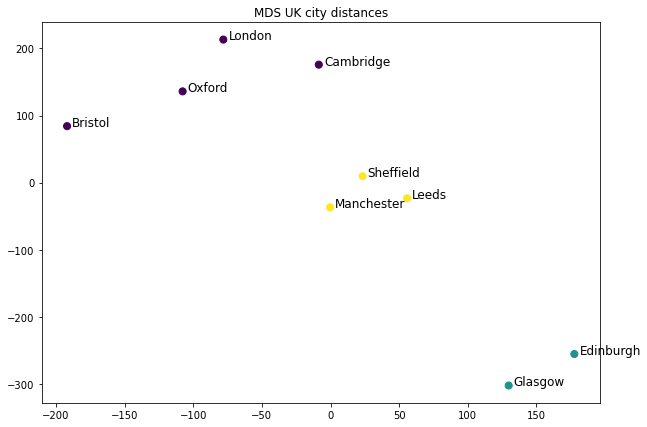

In [35]:
plot_clusters(npos_uk_dist, dfdis, 3, out_name='uk_mds_dist.png', title='MDS UK city distances')

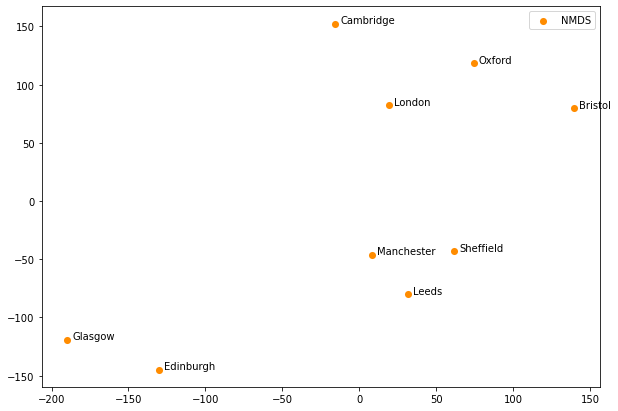

In [37]:
npos_uk_tr = mds_uk.fit_transform(dftr)
plot_mds(dftr, npos_uk_tr, out_name='train_dist.png')

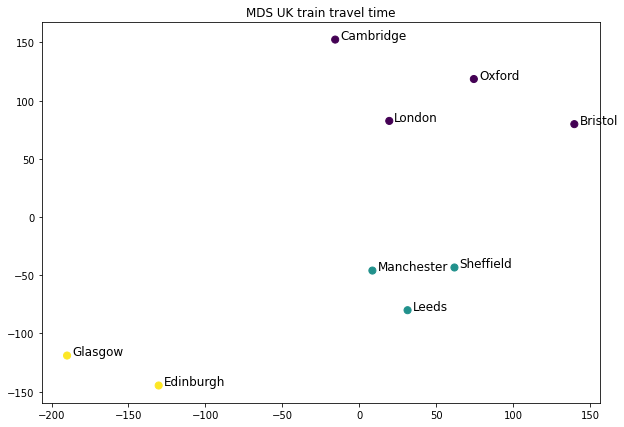

In [38]:
plot_clusters(npos_uk_tr, dftr, 3, out_name='uk_mds_train.png', title='MDS UK train travel time')

## Using eigendecomposition

In [39]:
# https://www.nervouscomputer.com/hfs/cmdscale-in-python/
def cmdscale(D):
    """                                                                                       
    Classical multidimensional scaling (MDS)                                                  
                                                                                               
    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            
                                                                                               
    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        
                                                                                               
    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     
                                                                                               
    """
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
 
    return Y, evals

In [40]:
y, ev = cmdscale(dfdis)

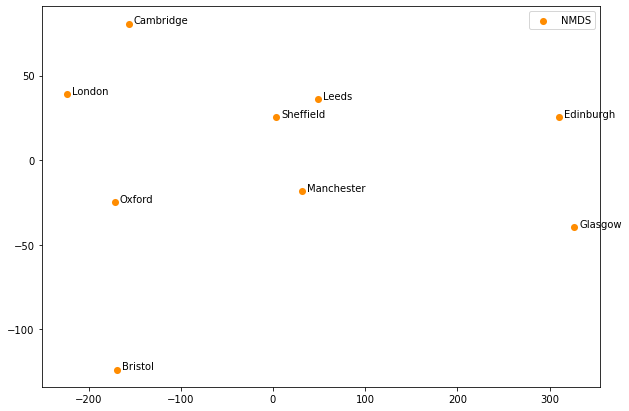

In [41]:
plot_mds(dfdis, y)

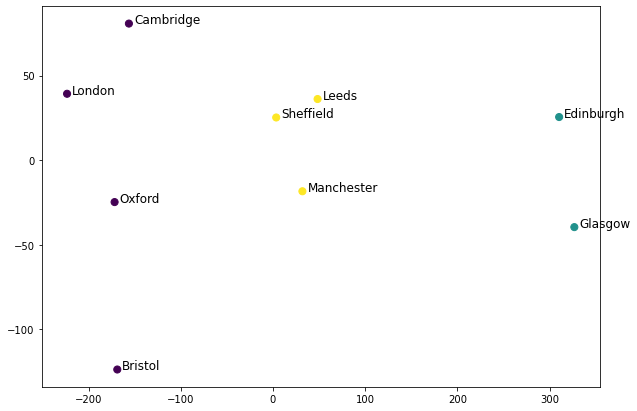

In [42]:
plot_clusters(y, dfdis, n_clusters=3)